# Text Classification

<hr>

This notebook presents an example of the practical exercises from Chapter Two of Book [Natural Language Processing with Transformers](https://www.oreilly.com/library/view/natural-language-processing/9781098136789/).

Created by [Anderson Silva](https://github.com/andsfonseca), Mayara Gomes and [Nelia Reis](https://github.com/neliareis).

<hr>

This notebook has references to other notebooks and codes such as:

* [One-hot Vectors](./2-text-classification/one_hot_vector.ipynb)


In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from transformers import DistilBertTokenizer, AutoModel
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

## The Dataset

To build our emotion detector we’ll use a great dataset from an article that explored
how emotions are represented in English Twitter messages, called [CARER: Contextualized Affect Representations for Emotion Recognition](http://dx.doi.org/10.18653/v1/D18-1404).

### A First Look at Hugging Face Datasets

We will use Datasets to download the data from the Hugging Face Hub. You can also access the list of all datasets from this [repository](https://github.com/huggingface/datasets).

In [1]:
from datasets import load_dataset

In [3]:
# Load the emotion dataset with the load_dataset() function:
emotions = load_dataset("emotion")
emotions

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/andsfonseca/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
# We can use the usual dictionary syntax to access an individual split:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
# Getting some information about the dataset:
print("Length: ", len(train_ds))
print("Column names:", train_ds.column_names)
print("Values: ", train_ds.features)
print("Access a single example by its index:", train_ds[0])

Length:  16000
Column names: ['text', 'label']
Values:  {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
Access a single example by its index: {'text': 'i didnt feel humiliated', 'label': 0}


### From Datasets to DataFrames

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a **Dataset** object to a **Pandas DataFrame** so we can access high-level APIs for data visualization.

In [6]:
import pandas as pd

In [7]:
# The set_format() method that allows us to change the output format of the Dataset.
emotions.set_format(type="pandas")

df_train = emotions["train"][:]
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
# Creating a method to show the label name and put in a new column in our DataFrame with the corresponding label:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [9]:
df_train["label_name"] = df_train["label"].apply(label_int2str)
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes.

In [23]:
import matplotlib.pyplot as plt

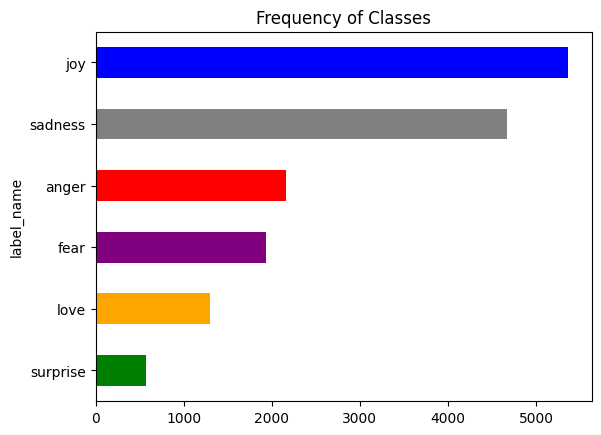

In [44]:

df_train["label_name"].value_counts(ascending=True).plot(kind='barh', color=["g", "orange", "purple", "r", "gray", "b"])

plt.title("Frequency of Classes")
plt.show()

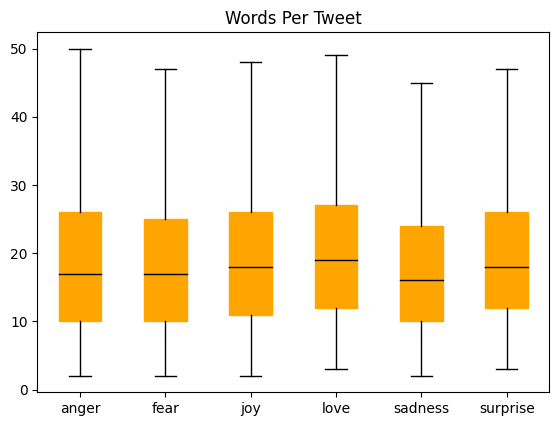

In [9]:
df_train["Words Per Tweet"] = df_train["text"].str.split().apply(len)

props = dict(boxes="Orange", whiskers="Black", medians="Black", caps="Black")
boxplot = df_train.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color=props, patch_artist=True)

plt.suptitle("")
plt.xlabel("")
plt.show()

In [10]:
emotions.reset_format()

### From Text to Tokens


#### Character Tokenization

In [11]:
example_text = df_train["text"][31]
example_text

'i remember feeling acutely distressed for a few days'

In [12]:
tokenized_example_text = list(example_text)
print(tokenized_example_text)

['i', ' ', 'r', 'e', 'm', 'e', 'm', 'b', 'e', 'r', ' ', 'f', 'e', 'e', 'l', 'i', 'n', 'g', ' ', 'a', 'c', 'u', 't', 'e', 'l', 'y', ' ', 'd', 'i', 's', 't', 'r', 'e', 's', 's', 'e', 'd', ' ', 'f', 'o', 'r', ' ', 'a', ' ', 'f', 'e', 'w', ' ', 'd', 'a', 'y', 's']


In [13]:
token2id_example = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_example_text)))}
print(token2id_example)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'i': 8, 'l': 9, 'm': 10, 'n': 11, 'o': 12, 'r': 13, 's': 14, 't': 15, 'u': 16, 'w': 17, 'y': 18}


In [14]:
tokenized_example_ids = [token2id_example[token] for token in tokenized_example_text]
print(tokenized_example_ids)

[8, 0, 13, 5, 10, 5, 10, 2, 5, 13, 0, 6, 5, 5, 9, 8, 11, 7, 0, 1, 3, 16, 15, 5, 9, 18, 0, 4, 8, 14, 15, 13, 5, 14, 14, 5, 4, 0, 6, 12, 13, 0, 1, 0, 6, 5, 17, 0, 4, 1, 18, 14]


<hr style="height:2px;border:none;background-color:gray;"></hr>

##### One-hot vectors

Each token has now been mapped to a unique numerical identifier (hence the name input_ids). The last step is to convert input_ids to a 2D tensor of one-hot vectors. You can see a example in this notebook [One-hot Vectors](./2-text-classification/one_hot_vector.ipynb)

<hr style="height:2px;border:none;background-color:gray;"></hr>

In [15]:
input_ids = torch.tensor(tokenized_example_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2id_example))
one_hot_encodings.shape

torch.Size([52, 19])

In [16]:
print(f"Token: {tokenized_example_text[0]}")
print(f"Tensor index: {tokenized_example_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: i
Tensor index: 8
One-hot: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

In [17]:
tokenized_word_example_text = example_text.split()
tokenized_word_example_text

['i',
 'remember',
 'feeling',
 'acutely',
 'distressed',
 'for',
 'a',
 'few',
 'days']

In [18]:
token2id_word_example = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_word_example_text)))}
print(token2id_word_example)

{'a': 0, 'acutely': 1, 'days': 2, 'distressed': 3, 'feeling': 4, 'few': 5, 'for': 6, 'i': 7, 'remember': 8}


In [19]:
tokenized_word_example_ids = [token2id_word_example[token] for token in tokenized_word_example_text]
print(tokenized_word_example_ids)

[7, 8, 4, 1, 3, 6, 0, 5, 2]


In [20]:
input_ids = torch.tensor(tokenized_word_example_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2id_word_example))
print(f"Token: {tokenized_word_example_text[2]}")
print(f"Tensor index: {tokenized_word_example_ids[2]}")
print(f"One-hot: {one_hot_encodings[2]}")

Token: feeling
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0])


#### Subword Tokenization

In [21]:
model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [22]:
# gerando os tokens usando Distilbert Tokenizer
encoded_text = distilbert_tokenizer(example_text)

print(example_text)
print(encoded_text["input_ids"])

i remember feeling acutely distressed for a few days
[101, 1045, 3342, 3110, 11325, 2135, 24305, 2005, 1037, 2261, 2420, 102]


In [23]:
# vendo os tokens
tokens = distilbert_tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'i',
 'remember',
 'feeling',
 'acute',
 '##ly',
 'distressed',
 'for',
 'a',
 'few',
 'days',
 '[SEP]']

In [24]:
# convertendo os tokens para texto
distilbert_tokenizer.convert_tokens_to_string(tokens)

'[CLS] i remember feeling acutely distressed for a few days [SEP]'

In [25]:
# tamanho do vocabulário
distilbert_tokenizer.vocab_size

30522

In [26]:
# tamanho máximo do contexto
distilbert_tokenizer.model_max_length

512

In [27]:
# nomes dos campos que o modelo espera
distilbert_tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the Whole Dataset

In [28]:
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
print(tokenize(emotions["train"][:2])["input_ids"])

[[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]]


|   Special Token  | [PAD] | [UNK] | [CLS] | [SEP] | [MASK] |
|:----------------:|:-----:|:-----:|:-----:|:-----:|:------:|
| Special Token ID |   0   |  100  |  101  |  102  |   103  |

In [30]:
tokens = distilbert_tokenizer.convert_ids_to_tokens(tokenize(emotions["train"][:2])["input_ids"][0])
tokens

['[CLS]',
 'i',
 'didn',
 '##t',
 'feel',
 'humiliated',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [31]:
# aplicando em todo o dataset a função tokenizadora
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [32]:
for i in range(1):
    row = emotions_encoded["train"][i]  
    print(row["text"]) 
    print(row["input_ids"]) 


i didnt feel humiliated
[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Training a Text Classifier

* Feature Extraction
* Fine-tuning

### Transformers as Feature Extractor

#### Using pretrained models

In [33]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

d:\Users\neliareis\Documents\workspace\JupyterNotebook\nlp-with-transformers\.conda\lib\site-packages\huggingface_hub-0.13.3-py3.8.egg\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\neliareis\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
Some weights of the model checkpoint at distilbert-base-uncased were not used 

#### Extracting the last hidden states

In [34]:
example_text

'i remember feeling acutely distressed for a few days'

In [35]:

inputs = distilbert_tokenizer(example_text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 12])


In [36]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[ 0.0267,  0.0243, -0.1351,  ...,  0.0231,  0.1226,  0.2348],
         [ 0.3981,  0.1839, -0.3101,  ...,  0.1541,  0.6333,  0.0120],
         [-0.0371,  0.1825, -0.0489,  ...,  0.0914, -0.3788, -0.2676],
         ...,
         [-0.2624, -0.3020,  0.2109,  ..., -0.3921, -0.6568, -0.0390],
         [-0.2264, -0.1025, -0.0399,  ..., -0.1844, -0.3466, -0.4665],
         [ 0.9699,  0.1726, -0.3798,  ...,  0.2346, -0.4845, -0.4161]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [37]:
outputs.last_hidden_state.size()

torch.Size([1, 12, 768])

In [38]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [39]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in distilbert_tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [40]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [41]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=512)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [42]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### Creating a feature matrix

In [43]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set

In [44]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.585996,6.907327,0
1,-2.766118,6.337205,0
2,5.451249,3.316218,3
3,-2.084089,4.079987,2
4,-3.048533,4.399386,3


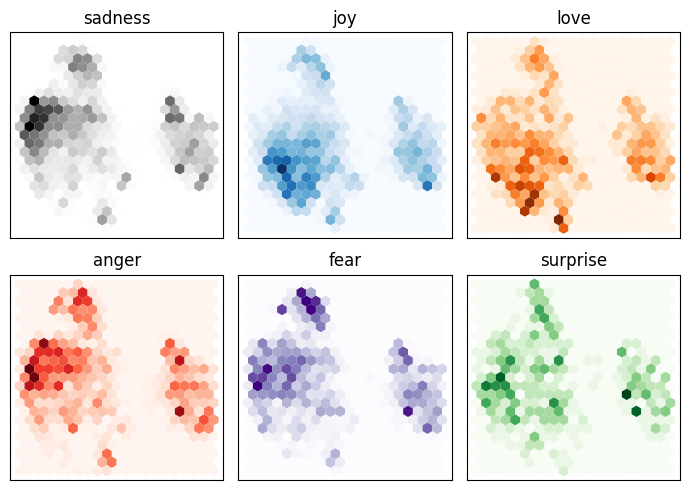

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

#### Training a simple classifier

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [48]:
from sklearn.dummy import DummyClassifier

In [49]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

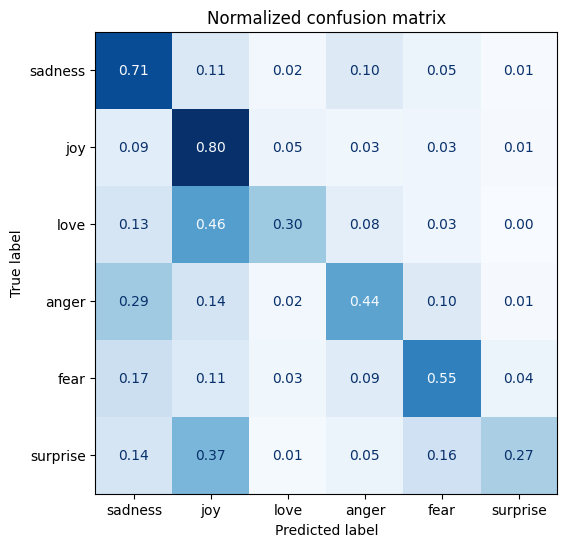

In [51]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Transformers

#### Loading a pretrained model

In [52]:
from transformers import AutoModelForSequenceClassification


In [53]:
num_labels = 6
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt, num_labels=num_labels)
 .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

#### Defining the performance metric

In [54]:
from sklearn.metrics import accuracy_score, f1_score

In [55]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

In [56]:
from transformers import Trainer, TrainingArguments

In [57]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
output_dir = f"models/{model_name}"
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [58]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=distilbert_tokenizer)
trainer.train()

d:\Users\neliareis\Documents\workspace\JupyterNotebook\nlp-with-transformers\.conda\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.8148, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3066568672657013, 'eval_accuracy': 0.9025, 'eval_f1': 0.8996762581606029, 'eval_runtime': 4.2882, 'eval_samples_per_second': 466.396, 'eval_steps_per_second': 7.462, 'epoch': 1.0}
{'loss': 0.2427, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.21136006712913513, 'eval_accuracy': 0.925, 'eval_f1': 0.9249168376743773, 'eval_runtime': 4.0608, 'eval_samples_per_second': 492.511, 'eval_steps_per_second': 7.88, 'epoch': 2.0}
{'train_runtime': 244.9863, 'train_samples_per_second': 130.62, 'train_steps_per_second': 2.041, 'train_loss': 0.5287845153808594, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5287845153808594, metrics={'train_runtime': 244.9863, 'train_samples_per_second': 130.62, 'train_steps_per_second': 2.041, 'train_loss': 0.5287845153808594, 'epoch': 2.0})

In [59]:
preds_output = trainer.predict(emotions_encoded["validation"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [60]:
preds_output.metrics

{'test_loss': 0.21136006712913513,
 'test_accuracy': 0.925,
 'test_f1': 0.9249168376743773,
 'test_runtime': 3.801,
 'test_samples_per_second': 526.181,
 'test_steps_per_second': 8.419}

In [61]:
y_preds = np.argmax(preds_output.predictions, axis=1)

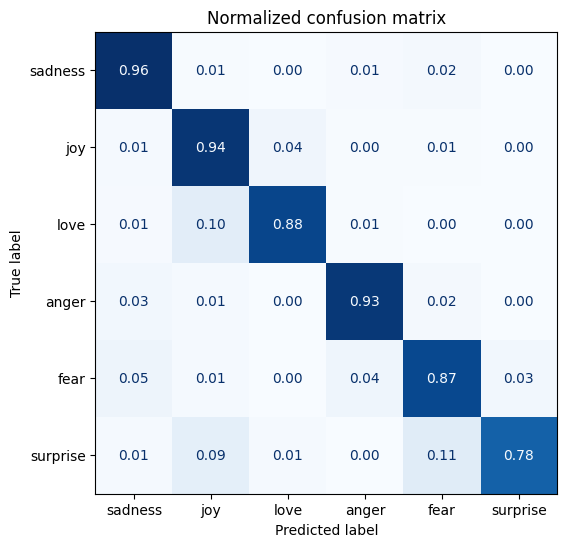

In [62]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### Error analysis

In [63]:
from torch.nn.functional import cross_entropy

In [64]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in distilbert_tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
        reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [65]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [66]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [67]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.698704
1801,i feel that he was being overshadowed by the s...,love,sadness,5.651400
882,i feel badly about reneging on my commitment t...,love,sadness,5.521354
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.498197
1509,i guess this is a memoir so it feels like that...,joy,fear,5.044833
1950,i as representative of everything thats wrong ...,surprise,sadness,4.906203
177,im sure much of the advantage is psychological...,sadness,joy,4.793894
1274,i am going to several holiday parties and i ca...,joy,sadness,4.419474
1840,id let you kill it now but as a matter of fact...,joy,fear,4.412551
1111,im lazy my characters fall into categories of ...,joy,fear,4.411312


In [68]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.016940
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.017040
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.017057
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.017090
76,i feel like im an unwelcome presence whenever ...,sadness,sadness,0.017122
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.017154
1041,i suppose it all goes along with feeling unwel...,sadness,sadness,0.017163
368,i have to admit that i m feeling quite gloomy ...,sadness,sadness,0.017243
375,i mention that i feel really unwelcome,sadness,sadness,0.017305
323,im starting to feel unwelcome in there,sadness,sadness,0.017486


In [69]:
from transformers import pipeline

In [77]:
classifier = pipeline("text-classification", model=model, tokenizer=distilbert_tokenizer, device=0)

In [78]:
example2_text = "I saw a movie today and it was really good."
preds = classifier(example2_text, return_all_scores=True)

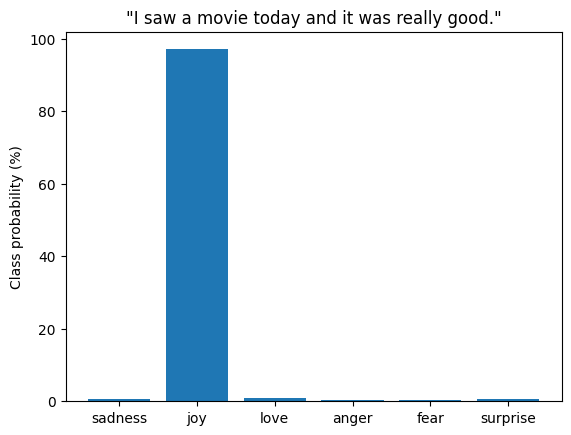

In [79]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{example2_text}"')
plt.ylabel("Class probability (%)")
plt.show()